In [154]:
from sympy import *
init_printing()
import numpy as np
import sys
import math

# Diffusion Monte Carlo propagators
Most of the equations taken from Chapter 24 ("Projector quantum Monte Carlo") in "Interacting Electrons" (2016) by R.M. Martin, L. Reining, and D.M. Ceperley.

# Trotter breakup

In [189]:
T_op = Symbol('That')   # Kinetic energy operator
V_op = Symbol('Vhat')   # Potential energy operator
tau = Symbol('tau')     # Projection time
n = Symbol('n',isinteger=True)  # Number of timestep divisions
dt = Symbol(r'\Delta\tau')  # Time for individual timestep

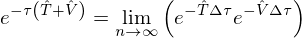

In [209]:
# Eq. 24.7
Eq(exp(-tau *(T_op + V_op)),
  Limit(exp(-dt*T_op) * exp(-dt*V_op),n,oo))

## In coordinate space, no importance sampling

In [211]:
R = Symbol('R')
Rp = Symbol("R'")
Rpp = Symbol("R''")
ET = Symbol("E_T") # Trial energy
N = Symbol('N',isinteger=True)  # number of particles
V = Symbol('V') # potential energy
bracket = lambda a,b,c : Symbol(r'\left\langle{%s}\left|{%s}\right|{%s}\right\rangle'%(latex(a),latex(b),latex(c)))

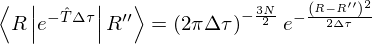

In [212]:
# Kinetic energy - Eq. 24.8
Eq(bracket(R, exp(-dt*T_op), Rpp),
  (2 *pi*dt)**(-3*N/2) * exp(-(R-Rpp)**2/(2*dt)))

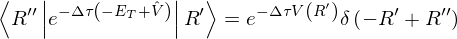

In [213]:
# Potential energy - Eq. 24.9
Eq(bracket(Rpp, exp(-dt*(V_op-ET)),Rp),
  exp(-dt*V(Rp))*DiracDelta(Rpp-Rp))

## In coordinate space, with importance sampling

In [116]:
F = Symbol('F_i')
psiG = Symbol('Psi_G',commutative=False)
EL = Symbol("E_L")  # Local energy
H_op = Symbol("Hhat",commutative=False)
gradient = lambda x: Symbol(r'\nabla{%s}'%latex(x))
gradient_with_index = lambda x,i : Symbol(r'\nabla_{%s}{%s}'%(latex(i),latex(x)))

In [117]:
# Quantum force
Eq(F(R), 2*gradient_with_index(log(psiG),Symbol('i')))

In [129]:
# Local energy
Eq(EL(R), psiG**-1 * H_op * psiG)

In [130]:
drift_diffusion = exp(-(Rp-R-S.Half*dt*F(R))**2/(2*dt))
drift_diffusion

In [123]:
branching = exp(-dt*(EL(R)-ET))
branching

In [127]:
prefactor = (2*pi*dt)**(-3*N/2)
prefactor

In [214]:
# Eq. 24.18
prefactor*drift_diffusion*branching

## Sampling the drift-diffusion term

In [138]:
chi = Symbol('chi')   # gaussian random sample with zero mean and variance delta tau
r = Symbol('r')
rp = Symbol("r'")

In [158]:
# Sample new positions with this formula  (Eq 23.13)
# Question - how to detemine sampling formula from evolution equation/distribution above?
sample_drift_diffusion = Eq(rp, r + dt * F + chi)
sample_drift_diffusion

## Scaling the drift

In QMCPACK, the drift term is scaled.  (From C. J. Umrigar, M. P. Nightingale, K. J. Runge "A diffusion Monte Carlo algorithm with very small time-step errors"  JCP 99, 2865 (1993) doi: 10.1063/1.465195 )

In [288]:
Fmag = Symbol('Fmag^2')
epsilon = Symbol('epsilon')

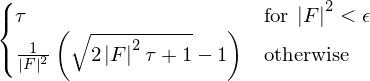

In [289]:
drift_scale = Piecewise( (tau,Fmag < epsilon ),
         ((sqrt(1 + 2*Fmag*tau)-1)/Fmag, True))
drift_scale

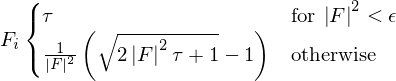

In [290]:
scaled_drift = F*drift_scale
scaled_drift

# Values for Testing

In [205]:
class SymPrinter(printing.lambdarepr.NumPyPrinter):
    def _print_Symbol(self, expr):
        if expr.name == r'\Delta\tau':
            return 'dt'
        return expr.name

In [206]:
# RNG corresponding to src/ParticleBase/RandomSeqGenerator.h
def gaussian_rng_list(n):
    input_rng = [0.5]*(n+1)
    slightly_less_than_one = 1.0 - sys.float_info.epsilon
    vals = []
    for i in range(0,n,2):
        temp1 = math.sqrt(-2.0 * math.log(1.0- slightly_less_than_one*input_rng[i]))
        temp2 = 2*math.pi*input_rng[i+1]
        vals.append(temp1*math.cos(temp2))
        vals.append(temp2*math.sin(temp2))
    if n%2 == 1:
        temp1 = math.sqrt(-2.0 * math.log(1.0- slightly_less_than_one*input_rng[n-1]))
        temp2 = 2*math.pi*input_rng[n]
        vals.append(temp1*math.cos(temp2))
    return vals

chi_vals = np.array(gaussian_rng_list(6)).reshape((2,3))
chi_vals
        

array([[ -1.17741002e+00,   3.84734139e-16,  -1.17741002e+00],
       [  3.84734139e-16,  -1.17741002e+00,   3.84734139e-16]])

In [240]:
r_vals = np.array( [ [1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0]])
tau_val = 0.1
scaled_chi_vals = chi_vals * math.sqrt(tau_val)

In [241]:
drift_diffuse_func = lambdify((r, F, chi, dt),sample_drift_diffusion.rhs, printer=SymPrinter)
scaled_drift_func = lambdify((tau, Fmag, F), scaled_drift.subs(epsilon, sys.float_info.epsilon) )
# For a constant wavefunction, gradient is zero
for r_val, chi_val in zip(r_vals, scaled_chi_vals):
    rp_val = np.zeros(3)
    rp_val = drift_diffuse_func(r_val, np.zeros(3), chi_val, tau_val)
    print rp_val

[  6.27670259e-01   1.21663617e-16  -3.72329741e-01]
[  1.21663617e-16  -3.72329741e-01   1.00000000e+00]


In [286]:
#  For a linear wavefunction, gradient is constant
grad_coeff = np.array([ 1.0, 2.0, 3.0])
for r_val, chi_val in zip(r_vals, scaled_chi_vals):
    rp_val = np.zeros(3)
    # Scaled drift is already multiplied by dt, accomodate by setting dt param to 1.0
    rp_val = drift_diffuse_func(r_val, scaled_drift_func(tau_val, np.dot(grad_coeff, grad_coeff),grad_coeff), chi_val, 1.0)
    print ['%.15g'%v for v in rp_val]

['0.695481606677082', '0.135622695565971', '-0.168895697756948']
['0.0678113477829853', '-0.236707045539933', '1.20343404334896']


In [287]:
# Compute scaled drift
drift_scale.subs({epsilon:sys.float_info.epsilon, tau:tau_val, Fmag:np.dot(grad_coeff, grad_coeff)})